In [23]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ROOT
from pathlib import Path
import mplhep as hep

hep.style.use(hep.style.ATLAS)

import re
import joblib
import logging
from utils.utils import check_inputpath, check_outputpath, logging_setup

# Comapre GM 450GeV 

## Cutflow

In [24]:
# GMH5_m450_ROOT = ROOT.TFile.Open(GM_sig_m450_path.as_posix())
# GMH5_m450_ROOT.ls()

In [25]:
# c1 = ROOT.TCanvas("c1", "c1", 800, 600)
# GMH5_m450_ROOT.Get("event_CutFlow").Draw()
# c1.Draw()

In [26]:
GM_sig_m450_path = "../Run2_WZ_samples/decorated/GM_sig/resonance.450770_MGaMcAtNloPy8EG_A14NNPDF23LO_vbfGM_sH05_H5pWZ_lvll_m450_ntuples.root"
GM_sig_m450_path = Path(GM_sig_m450_path)

## Check GM H5 mass = 450 GeV

In [27]:
GM_sig_m450 = uproot.open(GM_sig_m450_path)

In [28]:
GM_sig_m450.keys()

['nominal;1']

In [29]:
nominal_branchs = GM_sig_m450["nominal"].keys()[0:93] + ["Ht", "pSignal_GM"]
GM_sig_m450_nominal_branches = GM_sig_m450["nominal"].arrays(
    nominal_branchs, library="pd"
)

In [30]:
for branch in nominal_branchs:
    print(branch)

Yields
isMC
Channel
Year
NormSF
WeightSign
WeightNormalized
Weight
M_WZ
M_123
Mt_WZ
M_Z
Mt_W
Met
Njets
NBjets
SumOfWeight
Luminosity
CrossSection
WZInclusiveLoose
WZInclusive
WZqqSR
WZqqCR
WZVBSSR
WZVBSCR
ZfakeElCR
ZfakeMuCR
ZfakeCR
TopElCR
TopMuCR
TopCR
ZZCR
EventNumber
AvMu
M_jj
Deta_jj
DY_jj
Dphi_jj
PtBalanceZ
PtBalanceW
ZetaLep
Sum3Pt
Pt_123
Pt_WZ
Pt_W
Pt_Z
Eta_W
Eta_Z
LTcode
TruthType
genMass
Jet1Pt
Jet2Pt
Jet3Pt
Jet1Eta
Jet2Eta
Jet3Eta
Jet1Phi
Jet2Phi
Jet3Phi
Jet1E
Jet2E
Jet3E
Jet1Y
Jet2Y
Jet3Y
Jet1Truth
Jet2Truth
Jet3Truth
Lep1Pt
Lep2Pt
Lep3Pt
Lep1Eta
Lep2Eta
Lep3Eta
Lep1Phi
Lep2Phi
Lep3Phi
Lep1Charge
Lep2Charge
Lep3Charge
Lep1D0Sig
Lep2D0Sig
Lep3D0Sig
Lep1WeightZ
Lep2WeightZ
Lep3WeightZ
Lep1WeightW
Lep2WeightW
Lep3WeightW
Lep1Level
Lep2Level
Lep3Level
Ht
pSignal_GM


In [31]:
##### Add cuts accrording to the table 1
cut_GM_sig_m450 = GM_sig_m450_nominal_branches.copy()
training_cutflow = {}
# WZInclusive
cut_GM_sig_m450 = cut_GM_sig_m450.loc[cut_GM_sig_m450["WZInclusive"] == 1]
training_cutflow["Cut WZInclusive"] = len(cut_GM_sig_m450)
print(f"Cut WZInclusive: {len(cut_GM_sig_m450)}")

# N_j >= 2
cut_GM_sig_m450 = cut_GM_sig_m450.loc[cut_GM_sig_m450["Njets"] >= 2]
training_cutflow["Cut Njets>=2"] = len(cut_GM_sig_m450)
print(f"Cut Njets>=2: {len(cut_GM_sig_m450)}")

# b-jet veto
cut_GM_sig_m450 = cut_GM_sig_m450.loc[cut_GM_sig_m450["NBjets"] == 0]
training_cutflow["Cut NBjets==0"] = len(cut_GM_sig_m450)
print(f"Cut NBjets==0: {len(cut_GM_sig_m450)}")

# M_jj > 100 GeV
cut_GM_sig_m450 = cut_GM_sig_m450.loc[cut_GM_sig_m450["M_jj"] >= 100]
training_cutflow["Cut M_jj>100GeV"] = len(cut_GM_sig_m450)
print(f"Cut M_jj>100GeV: {len(cut_GM_sig_m450)}")

training_cutflow = pd.DataFrame(
    {
        "training_cutflow": training_cutflow.keys(),
        "cut_yield": training_cutflow.values(),
    }
)

Cut WZInclusive: 75096
Cut Njets>=2: 43702
Cut NBjets==0: 42699
Cut M_jj>100GeV: 40272


In [32]:
training_cutflow

,training_cutflow,cut_yield
0,Cut WZInclusive,75096
1,Cut Njets>=2,43702
2,Cut NBjets==0,42699
3,Cut M_jj>100GeV,40272


# Check all H5 masses

In [33]:
##### Reproduce table 11

In [34]:
input_path = "../Run2_WZ_samples/decorated"
input_path = Path(input_path)
check_inputpath(input_path)

GM_sig_path = input_path / "GM_sig"

In [35]:
def apply_training_cut(GM_sig_m_nominal_branches):
    cut_GM_sig_m = GM_sig_m_nominal_branches.copy()
    training_cutflow = {}
    # WZInclusive
    cut_GM_sig_m = cut_GM_sig_m.loc[cut_GM_sig_m["WZInclusive"] == 1]
    training_cutflow["Cut WZInclusive"] = len(cut_GM_sig_m)

    # N_j >= 2
    cut_GM_sig_m = cut_GM_sig_m.loc[cut_GM_sig_m["Njets"] >= 2]
    training_cutflow["Cut Njets>=2"] = len(cut_GM_sig_m)

    # b-jet veto
    cut_GM_sig_m = cut_GM_sig_m.loc[cut_GM_sig_m["NBjets"] == 0]
    training_cutflow["Cut NBjets==0"] = len(cut_GM_sig_m)

    # M_jj > 100 GeV
    cut_GM_sig_m = cut_GM_sig_m.loc[cut_GM_sig_m["M_jj"] >= 100]
    training_cutflow["Cut M_jj>100GeV"] = len(cut_GM_sig_m)

    training_cutflow = pd.DataFrame(
        {
            "training_cutflow": training_cutflow.keys(),
            "cut_yield": training_cutflow.values(),
        }
    )

    raw_event_yield = len(cut_GM_sig_m)
    normalized_event_yield = cut_GM_sig_m["WeightNormalized"].sum()

    return (
        cut_GM_sig_m,
        training_cutflow,
        raw_event_yield,
        normalized_event_yield,
    )

In [36]:
training_input_yield = {
    "mass": [],
    "raw_event_yield": [],
    "normalized_event_yield": [],
}

re_mass_pattern = r"m(\d+)(?=[_ntuples,_lepfilt])"

merged_sig = []

for GM_sig_file in sorted(GM_sig_path.glob("*.root")):
    GM_sig_file_name = GM_sig_file.name
    match = re.search(re_mass_pattern, GM_sig_file_name)
    if match:
        mass = match.group(1)
        mass = int(mass)
    else:
        raise ValueError("No mass found in file name")

    GM_sig_file = uproot.open(GM_sig_file)
    nominal_branchs = GM_sig_file["nominal"].keys()[0:93] + [
        "Ht",
        "pSignal_GM",
    ]
    GM_sig_m_nominal_branches = GM_sig_file["nominal"].arrays(
        nominal_branchs, library="pd"
    )

    (
        cut_GM_sig_m,
        training_cutflow,
        raw_event_yield,
        normalized_event_yield,
    ) = apply_training_cut(GM_sig_m_nominal_branches)

    merged_sig.append(cut_GM_sig_m)
    training_input_yield["mass"].append(mass)
    training_input_yield["raw_event_yield"].append(raw_event_yield)
    training_input_yield["normalized_event_yield"].append(
        normalized_event_yield
    )

In [37]:
training_input_yield = pd.DataFrame(training_input_yield)
merged_sig = pd.concat(merged_sig)

In [38]:
training_input_yield.loc["Total"] = training_input_yield.sum()

In [39]:
training_input_yield

,mass,raw_event_yield,normalized_event_yield
0,200.0,12153.0,152.474777
1,250.0,27175.0,142.906448
2,300.0,30644.0,137.715607
3,350.0,37346.0,128.195175
4,400.0,42109.0,115.105957
5,450.0,40272.0,91.894867
6,500.0,46936.0,81.789330
7,225.0,23628.0,146.715729
8,275.0,29752.0,145.312027
9,325.0,35208.0,128.033997


In [40]:
joblib.dump(merged_sig, "merged_decorated_sig.pkl")

['merged_decorated_sig.pkl']

# Merge Bkg

In [41]:
bkg_path = input_path / "bkg"
check_inputpath(bkg_path)

PosixPath('../Run2_WZ_samples/decorated/bkg')

In [42]:
training_input_yield_bkg = {
    "name": [],
    "raw_event_yield": [],
    "normalized_event_yield": [],
}

merged_bkg = []

for bkg_file in sorted(bkg_path.glob("*.root")):
    bkg_file_name = bkg_file.name
    bkg_file = uproot.open(bkg_file)
    nominal_branchs = bkg_file["nominal"].keys()[0:93] + ["Ht", "pSignal_GM"]
    bkg_nominal_branches = bkg_file["nominal"].arrays(
        nominal_branchs, library="pd"
    )

    (
        cut_bkg,
        training_cutflow,
        raw_event_yield,
        normalized_event_yield,
    ) = apply_training_cut(bkg_nominal_branches)
    merged_bkg.append(cut_bkg)
    training_input_yield_bkg["name"].append(bkg_file_name)
    training_input_yield_bkg["raw_event_yield"].append(raw_event_yield)
    training_input_yield_bkg["normalized_event_yield"].append(
        normalized_event_yield
    )

In [43]:
training_input_yield_bkg = pd.DataFrame(training_input_yield_bkg)

In [44]:
training_input_yield_bkg.loc["Total"] = training_input_yield_bkg.sum()

In [45]:
training_input_yield_bkg

,name,raw_event_yield,normalized_event_yield
0,resonance.364253_Sherpa_222_NNPDF30NNLO_lllv_n...,816454,2973.739502
1,resonance.364739_MGPy8EG_NNPDF30NLO_A14NNPDF23...,25815,40.750809
2,resonance.364740_MGPy8EG_NNPDF30NLO_A14NNPDF23...,35364,64.986855
3,resonance.364741_MGPy8EG_NNPDF30NLO_A14NNPDF23...,24430,38.421360
4,resonance.364742_MGPy8EG_NNPDF30NLO_A14NNPDF23...,30272,61.633919
Total,resonance.364253_Sherpa_222_NNPDF30NNLO_lllv_n...,932335,3179.532471


In [46]:
merged_bkg = pd.concat(merged_bkg)

In [47]:
np.sum(merged_bkg["WZVBSSR"])

116709

In [48]:
joblib.dump(merged_bkg, "merged_decorated_bkg.pkl")

['merged_decorated_bkg.pkl']

# Signal vs Bkg 

In [49]:
plots_path = Path("./plots_sigvsbkg")
check_outputpath(plots_path)

PosixPath('plots_sigvsbkg')

In [50]:
merged_sig.columns

Index(['Yields', 'isMC', 'Channel', 'Year', 'NormSF', 'WeightSign',
       'WeightNormalized', 'Weight', 'M_WZ', 'M_123', 'Mt_WZ', 'M_Z', 'Mt_W',
       'Met', 'Njets', 'NBjets', 'SumOfWeight', 'Luminosity', 'CrossSection',
       'WZInclusiveLoose', 'WZInclusive', 'WZqqSR', 'WZqqCR', 'WZVBSSR',
       'WZVBSCR', 'ZfakeElCR', 'ZfakeMuCR', 'ZfakeCR', 'TopElCR', 'TopMuCR',
       'TopCR', 'ZZCR', 'EventNumber', 'AvMu', 'M_jj', 'Deta_jj', 'DY_jj',
       'Dphi_jj', 'PtBalanceZ', 'PtBalanceW', 'ZetaLep', 'Sum3Pt', 'Pt_123',
       'Pt_WZ', 'Pt_W', 'Pt_Z', 'Eta_W', 'Eta_Z', 'LTcode', 'TruthType',
       'genMass', 'Jet1Pt', 'Jet2Pt', 'Jet3Pt', 'Jet1Eta', 'Jet2Eta',
       'Jet3Eta', 'Jet1Phi', 'Jet2Phi', 'Jet3Phi', 'Jet1E', 'Jet2E', 'Jet3E',
       'Jet1Y', 'Jet2Y', 'Jet3Y', 'Jet1Truth', 'Jet2Truth', 'Jet3Truth',
       'Lep1Pt', 'Lep2Pt', 'Lep3Pt', 'Lep1Eta', 'Lep2Eta', 'Lep3Eta',
       'Lep1Phi', 'Lep2Phi', 'Lep3Phi', 'Lep1Charge', 'Lep2Charge',
       'Lep3Charge', 'Lep1D0Sig', 'Lep2D0S

In [51]:
np.sum(merged_sig["WZVBSSR"])

698530

In [52]:
merged_sig["Jet3Truth"]

3        -999
11       -999
14       -999
16          1
22       -999
         ... 
136522   -999
136524   -999
136525   -999
136527   -999
136528   -999
Name: Jet3Truth, Length: 868074, dtype: int32

In [53]:
def compare_sigvsbkg(feature, merged_sig, merged_bkg):
    feature_min = np.min(
        [np.min(merged_sig[feature]), np.min(merged_bkg[feature])]
    )
    feature_max = np.max(
        [np.max(merged_sig[feature]), np.max(merged_bkg[feature])]
    )
    if feature == "M_jj":
        feature_min = 0
        feature_max = 5000
    elif feature == "Met":
        feature_min = 0
        feature_max = 400
    elif feature == "Jet1Pt":
        feature_min = 0
        feature_max = 600
    elif feature == "Jet2Pt":
        feature_min = 0
        feature_max = 300
    elif feature == "Ht":
        feature_min = 0
        feature_max = 1500

    feature_bins = np.linspace(feature_min, feature_max, 101)
    sig_bin_contents, sig_bin_edges = np.histogram(
        merged_sig[feature],
        bins=feature_bins,
        density=True,
        weights=merged_sig["WeightNormalized"],
    )
    bkg_bin_contents, bkg_bin_edges = np.histogram(
        merged_bkg[feature],
        bins=feature_bins,
        density=True,
        weights=merged_bkg["WeightNormalized"],
    )

    bin_content_max = np.max(
        [np.max(sig_bin_contents), np.max(bkg_bin_contents)]
    )
    fig, ax = plt.subplots()
    ax.set_xlim(feature_min, feature_max)
    ax.set_ylim(0, bin_content_max * 1.3)

    hep.histplot(
        sig_bin_contents, sig_bin_edges, label="Signal", ax=ax, color="red"
    )
    hep.histplot(
        bkg_bin_contents,
        bkg_bin_edges,
        label="Background",
        ax=ax,
        color="blue",
    )

    hep.atlas.label("Internal", data=False)
    hep.atlas.set_ylabel("Normalized to unity")
    hep.atlas.set_xlabel(feature)
    ax.legend()

    fig.savefig(plots_path / f"{feature}.png")

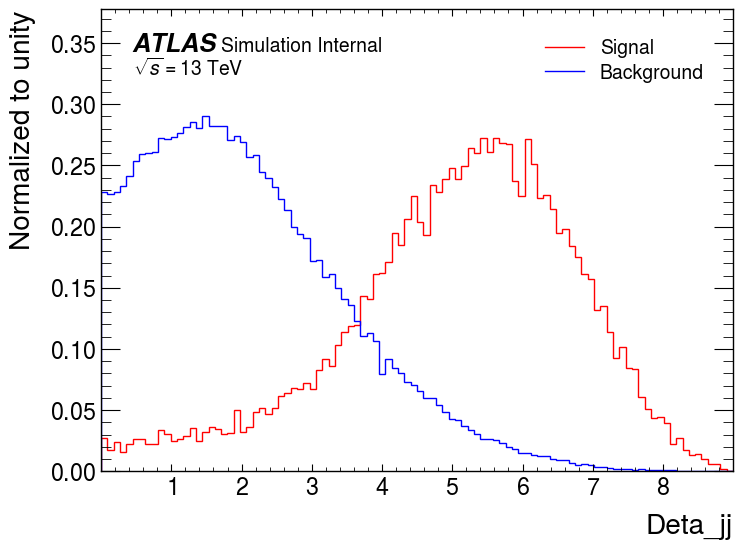

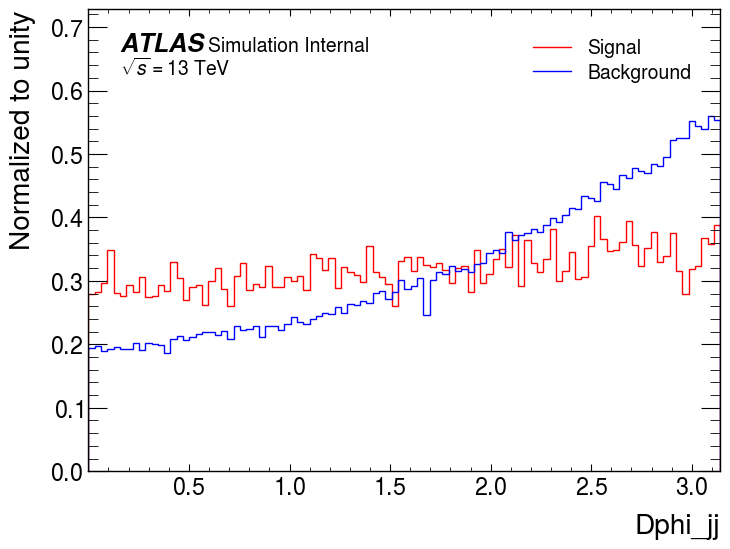

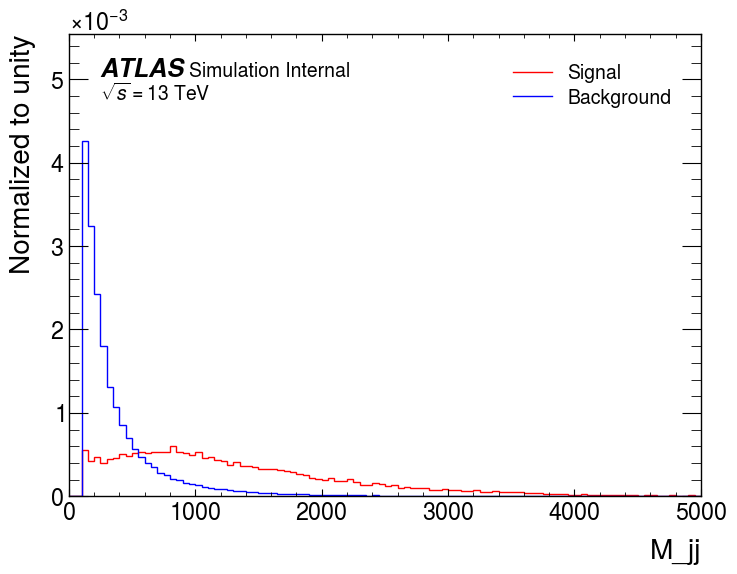

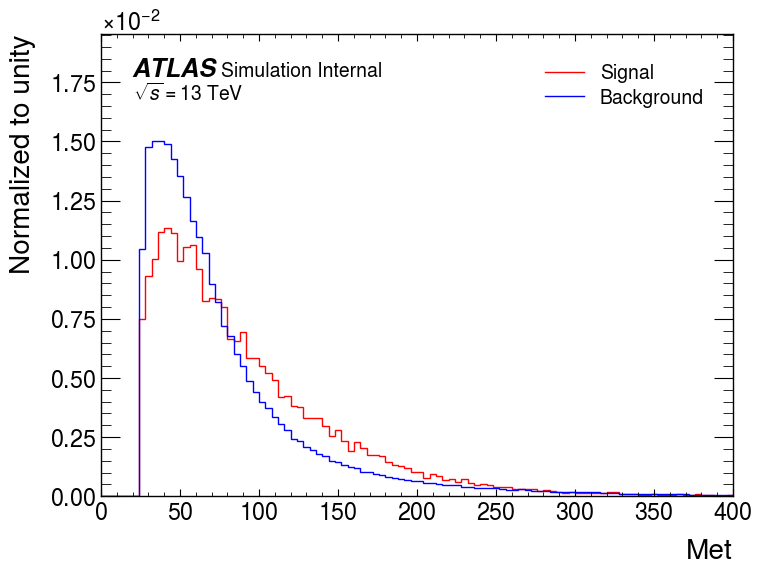

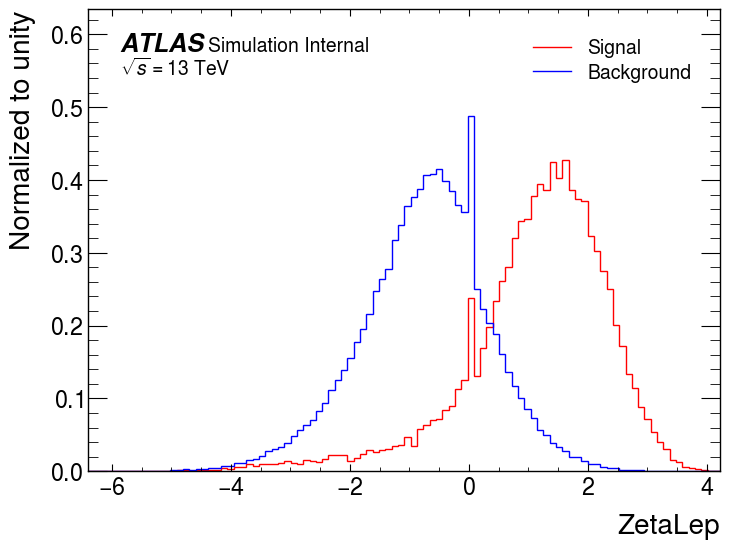

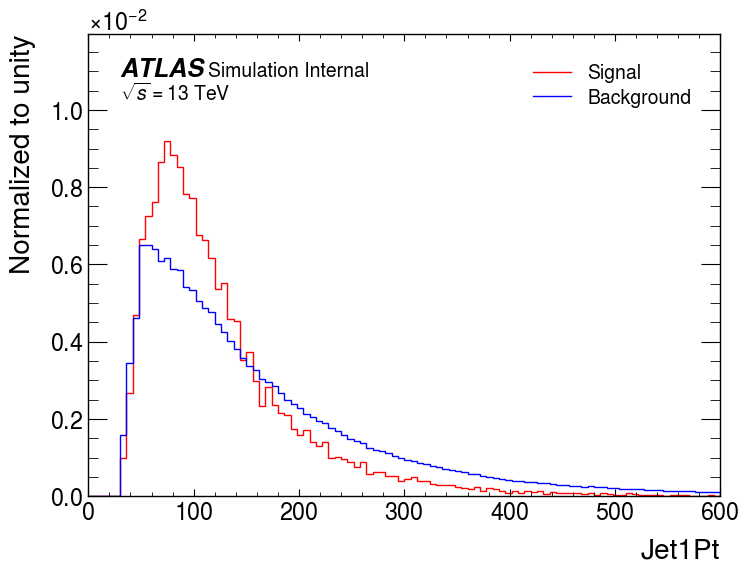

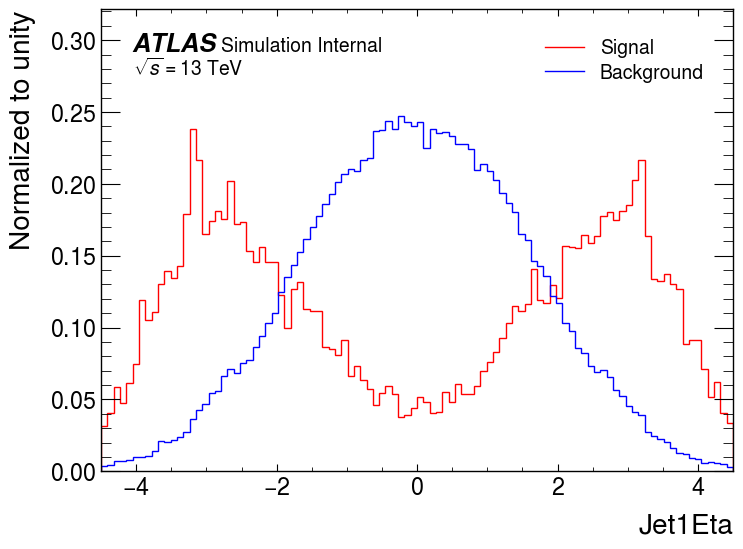

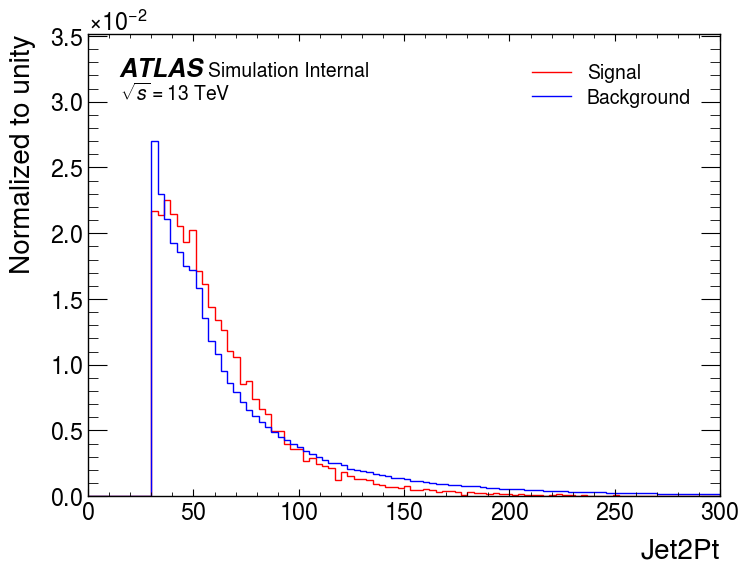

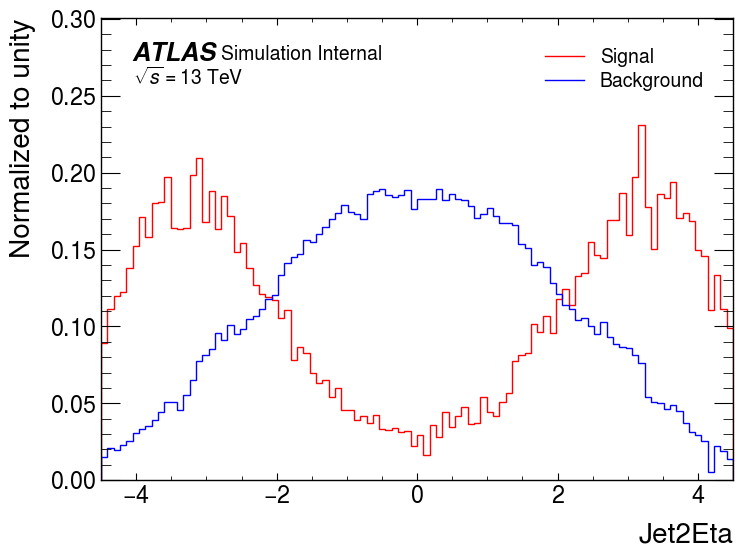

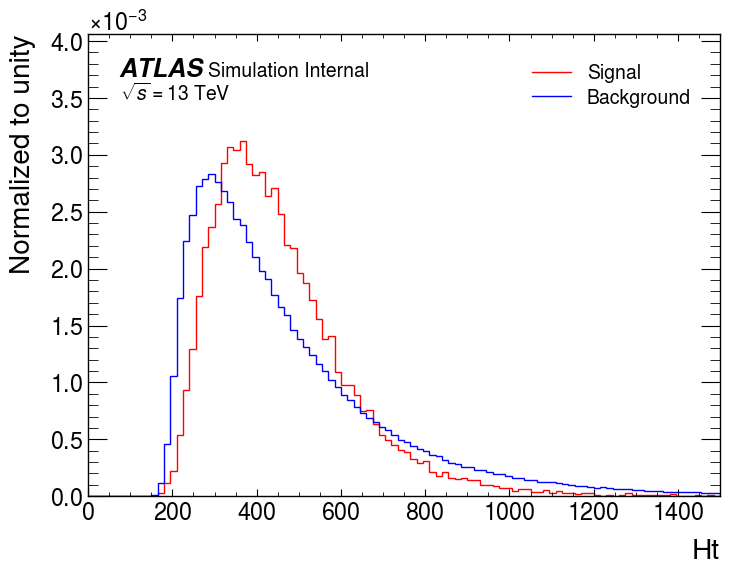

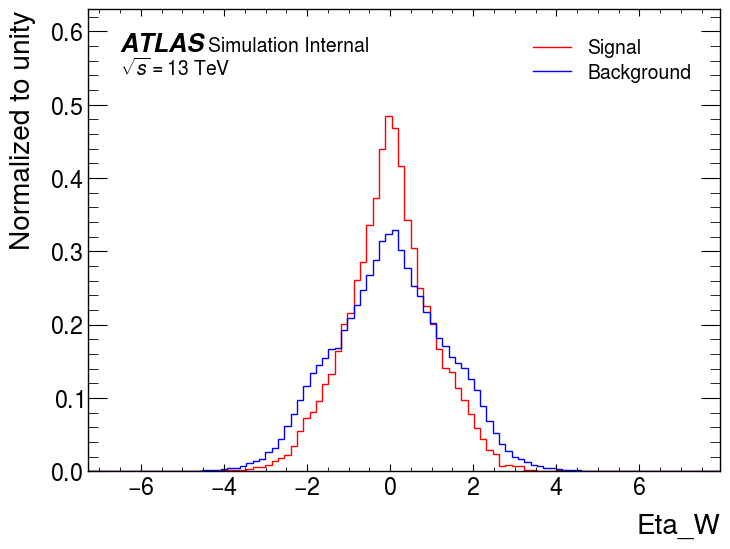

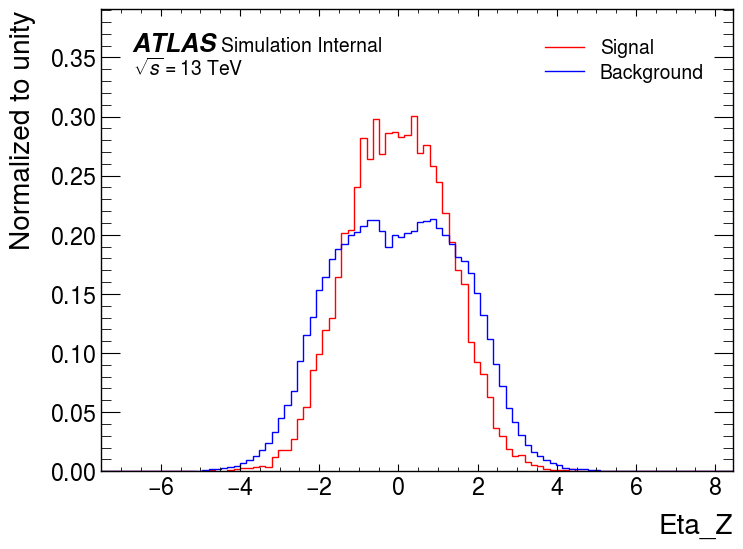

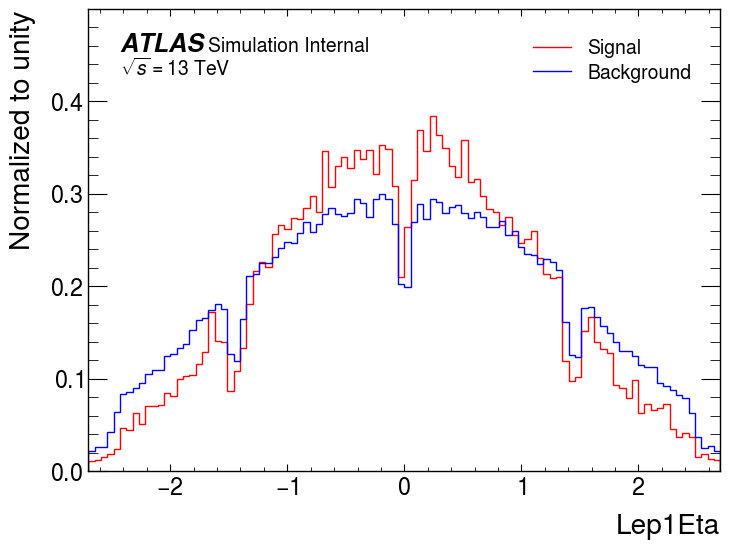

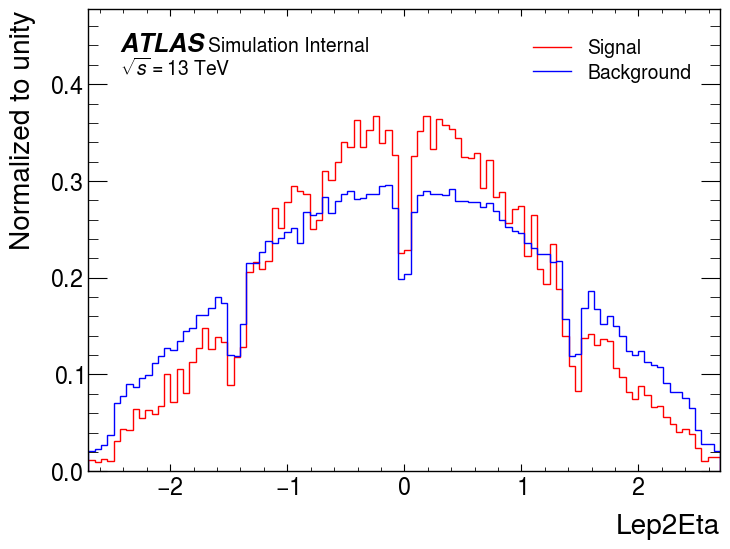

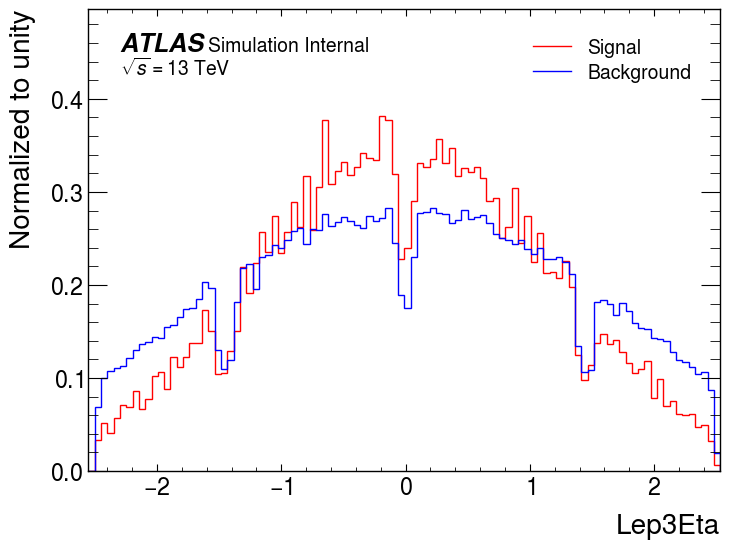

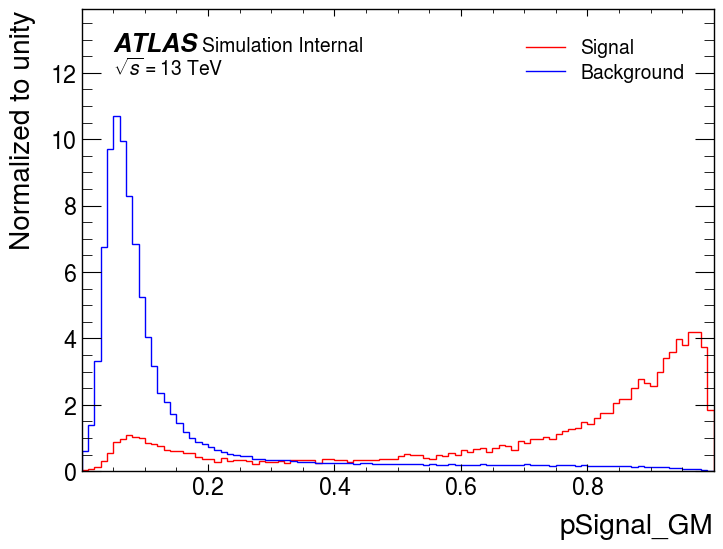

In [54]:
features = [
    "Deta_jj",
    "Dphi_jj",
    "M_jj",
    "Met",
    "ZetaLep",
    "Jet1Pt",
    "Jet1Eta",
    "Jet2Pt",
    "Jet2Eta",
    "Ht",
    "Eta_W",
    "Eta_Z",
    "Lep1Eta",
    "Lep2Eta",
    "Lep3Eta",
    "pSignal_GM",
]

for feature in features:
    compare_sigvsbkg(feature, merged_sig, merged_bkg)

(array([  8238.,  14008.,  28770.,  90882., 337400., 291923.,  64173.,
         19006.,   8696.,   4978.]),
 array([ 71.18843079,  75.18832397,  79.18821716,  83.18811798,
         87.18801117,  91.18790436,  95.18779755,  99.18769073,
        103.18759155, 107.18748474, 111.18737793]),
 <BarContainer object of 10 artists>)

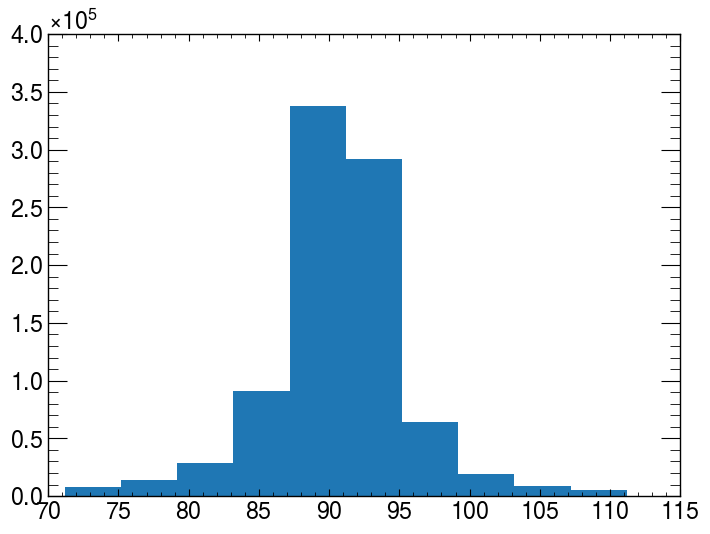

In [55]:
plt.hist(merged_sig["M_Z"])